# Load and View Dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

In [2]:
data_url="https://raw.githubusercontent.com/pck196/dataforproject/master/news-data.csv"
dataset = pd.read_csv(data_url)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [3]:
dataset.head()

,category,text
0,tech,tv future in the hands of viewers with home th...
1,business,worldcom boss left books alone former worldc...
2,sport,tigers wary of farrell gamble leicester say ...
3,sport,yeading face newcastle in fa cup premiership s...
4,entertainment,ocean s twelve raids box office ocean s twelve...


# Build Train and Test Datasets

In [4]:
# build train and test datasets
txtdt = dataset['text'].values
category = dataset['category'].values

train_txtdt = txtdt[:1560]
train_category = category[:1560]

test_txtdt = txtdt[1560:]
test_category = category[1560:]

# Data Visualization

In [5]:
uniq_categories=set(train_category)
uniq_categories

{'business', 'entertainment', 'politics', 'sport', 'tech'}

In [6]:
cat_values=[]
cat_lables=[]
lst_cat=list(train_category)

for catg in uniq_categories:
  cnt=0
  cnt=lst_cat.count(catg)
  print(catg)
  print(cnt)
  cat_lables.append(catg)
  cat_values.append(cnt)

print(cat_lables)
print(cat_values)


politics
288
entertainment
280
sport
354
tech
275
business
363
['politics', 'entertainment', 'sport', 'tech', 'business']
[288, 280, 354, 275, 363]


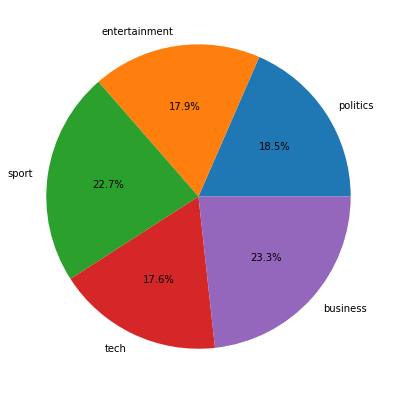

In [7]:
# Creating pie plot 
fig = plt.figure(figsize =(10, 7)) 
plt.pie(cat_values, labels = cat_lables,autopct='%1.1f%%')
plt.show() 

# Text Wrangling & Normalization

In [8]:
!pip install contractions
import nltk
import unicodedata
import re
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
import contractions

ps = nltk.porter.PorterStemmer()
stop_words = nltk.corpus.stopwords.words('english')

def expand_contractions(text):
    return contractions.fix(text)


def simple_stemming(text, stemmer=ps):
    text = ' '.join([stemmer.stem(word) for word in text.split()])
    return text


def remove_stopwords(text, is_lower_case=False, stopwords=None):
    if not stopwords:
        stopwords = nltk.corpus.stopwords.words('english')
    tokens = nltk.word_tokenize(text)
    tokens = [token.strip() for token in tokens]
    
    if is_lower_case:
        filtered_tokens = [token for token in tokens if token not in stopwords]
    else:
        filtered_tokens = [token for token in tokens if token.lower() not in stopwords]
    
    filtered_text = ' '.join(filtered_tokens)    
    return filtered_text

def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]' if not remove_digits else r'[^a-zA-Z\s]'
    text = re.sub(pattern, '', text)
    return text


def pre_process_document(document):
    
    # lower case
    document = document.lower()

    # remove accented characters
    document = remove_accented_chars(document)
    
    # expand contractions    
    document = expand_contractions(document)

    # remove special characters and\or digits
    # insert spaces between special characters to isolate them
    special_char_pattern = re.compile(r'([{.(-)!}])')
    document = special_char_pattern.sub(" \\1 ", document)
    document = remove_special_characters(document, remove_digits=True)  

    # stemming text
    document = simple_stemming(document)      
    
    # remove stopwords
    document = remove_stopwords(document, is_lower_case=True, stopwords=stop_words)

    # remove extra whitespace
    document = re.sub(' +', ' ', document)
    document = document.strip()
        
    
    return document


pre_process = np.vectorize(pre_process_document)

In [10]:
norm_train_txtdt = pre_process(train_txtdt)
norm_test_txtdt = pre_process(test_txtdt)

# Traditional Supervised Machine Learning Models

## Feature Engineering

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# build BOW features on train reviews
cv = CountVectorizer(binary=False, min_df=5, max_df=1.0, ngram_range=(1,2))
cv_train_features = cv.fit_transform(norm_train_txtdt)


# build TFIDF features on train reviews
tv = TfidfVectorizer(use_idf=True, min_df=5, max_df=1.0, ngram_range=(1,2),
                     sublinear_tf=True)
tv_train_features = tv.fit_transform(norm_train_txtdt)

In [12]:
# transform test reviews into features
cv_test_features = cv.transform(norm_test_txtdt)
tv_test_features = tv.transform(norm_test_txtdt)

In [13]:
print('BOW model:> Train features shape:', cv_train_features.shape, ' Test features shape:', cv_test_features.shape)
print('TFIDF model:> Train features shape:', tv_train_features.shape, ' Test features shape:', tv_test_features.shape)

BOW model:> Train features shape: (1560, 10722)  Test features shape: (665, 10722)
TFIDF model:> Train features shape: (1560, 10722)  Test features shape: (665, 10722)


## Model Training, Prediction and Performance Evaluation

In [14]:
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))



def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)

###Decesion Tree

In [15]:
# Decision Tree model on BOW features
from sklearn.tree import DecisionTreeClassifier

# instantiate model
dtc=DecisionTreeClassifier(max_leaf_nodes = 20, min_samples_leaf = 30, random_state=40)

# train model
dtc.fit(cv_train_features, train_category)

# predict on test data
dtc_bow_predictions = dtc.predict(cv_test_features)

In [16]:
get_metrics(true_labels=test_category, predicted_labels=dtc_bow_predictions)

Accuracy: 0.7579
Precision: 0.7816
Recall: 0.7579
F1 Score: 0.7556


In [17]:
display_classification_report(true_labels=test_category, predicted_labels=dtc_bow_predictions,
                                      classes=['entertainment', 'business', 'sport', 'tech', 'politics'])

               precision    recall  f1-score   support

entertainment       0.86      0.60      0.71       106
     business       0.63      0.89      0.74       147
        sport       0.76      0.83      0.79       157
         tech       0.85      0.58      0.69       126
     politics       0.85      0.81      0.83       129

     accuracy                           0.76       665
    macro avg       0.79      0.74      0.75       665
 weighted avg       0.78      0.76      0.76       665



In [18]:
# Decision Tree model on TF-IDF features

# train model
dtc.fit(tv_train_features, train_category)

# predict on test data
dtc_tfidf_predictions = dtc.predict(tv_test_features)

In [19]:
get_metrics(true_labels=test_category, predicted_labels=dtc_tfidf_predictions)

Accuracy: 0.7759
Precision: 0.7986
Recall: 0.7759
F1 Score: 0.7746


In [20]:
display_classification_report(true_labels=test_category, predicted_labels=dtc_tfidf_predictions,
                                      classes=['entertainment', 'business', 'sport', 'tech', 'politics'])

               precision    recall  f1-score   support

entertainment       0.88      0.60      0.72       106
     business       0.65      0.89      0.75       147
        sport       0.77      0.86      0.81       157
         tech       0.88      0.64      0.74       126
     politics       0.87      0.81      0.84       129

     accuracy                           0.78       665
    macro avg       0.81      0.76      0.77       665
 weighted avg       0.80      0.78      0.77       665



###Random Forest


In [21]:
# Random Forest model on BOW features
from sklearn.ensemble import RandomForestClassifier

# instantiate model
rf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)

# train model
rf.fit(cv_train_features, train_category)

# predict on test data
rf_bow_predictions = rf.predict(cv_test_features)

In [22]:
get_metrics(true_labels=test_category, predicted_labels=rf_bow_predictions)

Accuracy: 0.9609
Precision: 0.9611
Recall: 0.9609
F1 Score: 0.9609


In [23]:
display_classification_report(true_labels=test_category, predicted_labels=rf_bow_predictions,
                                      classes=['entertainment', 'business', 'sport', 'tech', 'politics'])

               precision    recall  f1-score   support

entertainment       0.97      0.95      0.96       106
     business       0.93      0.96      0.94       147
        sport       0.98      0.99      0.98       157
         tech       0.98      0.97      0.97       126
     politics       0.95      0.93      0.94       129

     accuracy                           0.96       665
    macro avg       0.96      0.96      0.96       665
 weighted avg       0.96      0.96      0.96       665



In [24]:
# Random Forest model on TF-IDF features

# train model
rf.fit(tv_train_features, train_category)

# predict on test data
rf_tfidf_predictions = rf.predict(tv_test_features)

In [25]:
get_metrics(true_labels=test_category, predicted_labels=rf_tfidf_predictions)

Accuracy: 0.9549
Precision: 0.9552
Recall: 0.9549
F1 Score: 0.9549


In [26]:
display_classification_report(true_labels=test_category, predicted_labels=rf_tfidf_predictions,
                                      classes=['entertainment', 'business', 'sport', 'tech', 'politics'])

               precision    recall  f1-score   support

entertainment       0.98      0.95      0.97       106
     business       0.92      0.95      0.93       147
        sport       0.97      0.99      0.98       157
         tech       0.97      0.97      0.97       126
     politics       0.94      0.91      0.92       129

     accuracy                           0.95       665
    macro avg       0.96      0.95      0.95       665
 weighted avg       0.96      0.95      0.95       665



###SVM

In [27]:
# SVM model on BOW features
from sklearn.svm import SVC

# instantiate model
svc=SVC(random_state=41)

# train model
svc.fit(cv_train_features, train_category)

# predict on test data
svc_bow_predictions = svc.predict(cv_test_features)

In [28]:
get_metrics(true_labels=test_category, predicted_labels=svc_bow_predictions)

Accuracy: 0.9579
Precision: 0.9586
Recall: 0.9579
F1 Score: 0.958


In [29]:
display_classification_report(true_labels=test_category, predicted_labels=svc_bow_predictions,
                                      classes=['entertainment', 'business', 'sport', 'tech', 'politics'])

               precision    recall  f1-score   support

entertainment       0.99      0.93      0.96       106
     business       0.95      0.95      0.95       147
        sport       0.99      0.98      0.99       157
         tech       0.92      0.97      0.95       126
     politics       0.94      0.95      0.94       129

     accuracy                           0.96       665
    macro avg       0.96      0.96      0.96       665
 weighted avg       0.96      0.96      0.96       665



In [30]:
# SVM model on TF-IDF features

# train model
svc.fit(tv_train_features, train_category)

# predict on test data
svc_tfidf_predictions = svc.predict(tv_test_features)

In [31]:
get_metrics(true_labels=test_category, predicted_labels=svc_tfidf_predictions)

Accuracy: 0.9805
Precision: 0.9804
Recall: 0.9805
F1 Score: 0.9804


In [32]:
display_classification_report(true_labels=test_category, predicted_labels=svc_tfidf_predictions,
                                      classes=['entertainment', 'business', 'sport', 'tech', 'politics'])

               precision    recall  f1-score   support

entertainment       0.99      0.99      0.99       106
     business       0.98      0.96      0.97       147
        sport       0.99      0.99      0.99       157
         tech       0.98      1.00      0.99       126
     politics       0.96      0.96      0.96       129

     accuracy                           0.98       665
    macro avg       0.98      0.98      0.98       665
 weighted avg       0.98      0.98      0.98       665



###Naive Bayes

In [33]:
# Naive Bayes model on BOW features
from sklearn.naive_bayes import GaussianNB

# instantiate model
gnb = GaussianNB()

# train model
gnb.fit(cv_train_features.toarray(), train_category)

# predict on test data
gnb_bow_predictions = gnb.predict(cv_test_features.toarray())

In [34]:
get_metrics(true_labels=test_category, predicted_labels=gnb_bow_predictions)

Accuracy: 0.9338
Precision: 0.935
Recall: 0.9338
F1 Score: 0.9336


In [35]:
display_classification_report(true_labels=test_category, predicted_labels=gnb_bow_predictions,
                                      classes=['entertainment', 'business', 'sport', 'tech', 'politics'])

               precision    recall  f1-score   support

entertainment       0.93      0.90      0.91       106
     business       0.94      0.86      0.90       147
        sport       0.99      0.99      0.99       157
         tech       0.88      0.98      0.93       126
     politics       0.91      0.93      0.92       129

     accuracy                           0.93       665
    macro avg       0.93      0.93      0.93       665
 weighted avg       0.94      0.93      0.93       665



In [36]:
# Naive Bayes model on TF-IDF features

# train model
gnb.fit(tv_train_features.toarray(), train_category)

# predict on test data
gnb_tfidf_predictions = gnb.predict(tv_test_features.toarray())

In [37]:
get_metrics(true_labels=test_category, predicted_labels=gnb_tfidf_predictions)

Accuracy: 0.9414
Precision: 0.9437
Recall: 0.9414
F1 Score: 0.9413


In [38]:
display_classification_report(true_labels=test_category, predicted_labels=gnb_tfidf_predictions,
                                      classes=['entertainment', 'business', 'sport', 'tech', 'politics'])

               precision    recall  f1-score   support

entertainment       0.98      0.90      0.94       106
     business       0.95      0.88      0.91       147
        sport       1.00      0.99      1.00       157
         tech       0.88      0.98      0.93       126
     politics       0.90      0.95      0.92       129

     accuracy                           0.94       665
    macro avg       0.94      0.94      0.94       665
 weighted avg       0.94      0.94      0.94       665

